# Understanding Dataset(s)

## Load necessary libraries

In [126]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd
import itertools
from AspectExtraction.utils import _readXML
from sklearn.preprocessing import MultiLabelBinarizer

## Load dataset(s)

In [103]:
data_parent_dir = "./Datasets/"
filenames = ["Restaurants_Train.xml", "restaurants-trial.xml", "Restaurants_Test_Data_phaseB.xml"]
datasets = list(map(lambda filename: _readXML(data_parent_dir + filename), filenames))
train, val, test = datasets

The class below allows us to output multiple object such as dataframes just by running one block. It makes use of the special ***\_repr_html_*** method, which IPython uses to implement its rich object display:

In [104]:
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

The first 5 rows of train, validation and test sets

In [105]:
display('train.head()', 'val.head()', 'test.head()')

,review,term,termPolarity,startIndex,endIndex,aspect,aspectPolarity
0,But the staff was so horrible to us.,[staff],[negative],[8],[13],[service],[negative]
1,"To be completely fair, the only redeeming fact...",[food],[positive],[57],[61],"[food, anecdotes/miscellaneous]","[positive, negative]"
2,"The food is uniformly exceptional, with a very...","[food, kitchen, menu]","[positive, positive, neutral]","[4, 55, 141]","[8, 62, 145]",[food],[positive]
3,Where Gabriela personaly greets you and recomm...,NaN,NaN,NaN,NaN,[service],[positive]
4,"For those that go once and don't enjoy it, all...",NaN,NaN,NaN,NaN,[anecdotes/miscellaneous],[positive]
,review,term,termPolarity,startIndex,endIndex,aspect,aspectPolarity
0,"All the appetizers and salads were fabulous, t...","[appetizers, salads, steak, pasta]","[positive, positive, positive, positive]","[8, 23, 49, 82]","[18, 29, 54, 87]",[food],[positive]
1,And really large portions.,[portions],[positive],[17],[25],[food],[positive]
2,Go inside and you won't want to leave.,NaN,NaN,NaN,NaN,[anecdotes/miscellaneous],[positive]
3,Save yourself the time and trouble and skip th...,NaN,NaN,NaN,NaN,[anecdotes/miscellaneous],[negative]


<span style="color:red;">***Note***</span> 

The test set has no label for ***termPolarity*** and ***aspectPolarity***. Also, there are some missing values in columns such as ***term***, ***termPolarity***, ***startIndex*** and ***endIndex***.

## Preliminary analysis
Number of sentences in each dataset

In [107]:
print("Train shape: {}".format(train.shape))
print("Val shape: {}".format(val.shape))
print("Test shape: {}".format(test.shape))

Train shape: (3044, 7)
Val shape: (100, 7)
Test shape: (800, 7)


Type of aspects (unique)

In [108]:
# Flatten list of list
def _flatten(l):
    return list(itertools.chain.from_iterable(l))

unique_asp = pd.unique(_flatten(train["aspect"]))
print("Aspects:", unique_asp)

Aspects: ['service' 'food' 'anecdotes/miscellaneous' 'price' 'ambience']


Number of sentences with different number of aspects

In [122]:
num_asp_table = train.groupby(train["aspect"].apply(len)).size().reset_index()
num_asp_table = num_asp_table.rename(columns={"aspect":"num of aspects", 0:"num_of_sent"})
num_asp_table.index +=1
num_asp_table.style.hide_index()

num of aspects,num_of_sent
1,2468
2,488
3,82
4,6


Number of sentences with different number of terms

- Number of implicit sentences (0 term)

In [121]:
# 0 terms
num_na_term = train["term"].isna().sum()
new_rows = pd.DataFrame(np.asarray([0, num_na_term]).reshape(1,2), columns=["num of terms", "num_of_sent"])
new_rows.index +=1
new_rows.style.hide_index()

num of terms,num_of_sent
0,1021


- Number of sentences with at least 1 term

In [120]:
# > 0 terms
temp = train.dropna(subset=["term"])
num_term_table = temp.groupby(temp["term"].apply(len)).size().reset_index()
num_term_table = num_term_table.rename(columns={"term":"num of terms", 0:"num_of_sent"})
# num_term_table = num_term_table.append(new_rows)
num_term_table.index +=1
num_term_table.style.hide_index()

num of terms,num_of_sent
1,1024
2,571
3,270
4,105
5,29
6,15
7,5
8,3
9,1


Number of sentences each aspect has

- Convert aspects to categorical columns which consist of binary value (0 and 1)

In [114]:
mlb = MultiLabelBinarizer()
categorical_aspects = pd.DataFrame(mlb.fit_transform(train["aspect"].values), columns=mlb.classes_, index=train.index)
train = pd.concat([train, categorical_aspects], axis=1)
categorical_aspects = pd.DataFrame(mlb.fit_transform(val["aspect"].values), columns=mlb.classes_, index=val.index)
val = pd.concat([val, categorical_aspects], axis=1)
categorical_aspects = pd.DataFrame(mlb.fit_transform(test["aspect"].values), columns=mlb.classes_, index=test.index)
test = pd.concat([test, categorical_aspects], axis=1)
display('train.head()', 'val.head()', 'test.head()')

,review,term,termPolarity,startIndex,endIndex,aspect,aspectPolarity,ambience,anecdotes/miscellaneous,food,price,service
0,But the staff was so horrible to us.,[staff],[negative],[8],[13],[service],[negative],0,0,0,0,1
1,"To be completely fair, the only redeeming fact...",[food],[positive],[57],[61],"[food, anecdotes/miscellaneous]","[positive, negative]",0,1,1,0,0
2,"The food is uniformly exceptional, with a very...","[food, kitchen, menu]","[positive, positive, neutral]","[4, 55, 141]","[8, 62, 145]",[food],[positive],0,0,1,0,0
3,Where Gabriela personaly greets you and recomm...,NaN,NaN,NaN,NaN,[service],[positive],0,0,0,0,1
4,"For those that go once and don't enjoy it, all...",NaN,NaN,NaN,NaN,[anecdotes/miscellaneous],[positive],0,1,0,0,0
,review,term,termPolarity,startIndex,endIndex,aspect,aspectPolarity,ambience,anecdotes/miscellaneous,food,price,service
0,"All the appetizers and salads were fabulous, t...","[appetizers, salads, steak, pasta]","[positive, positive, positive, positive]","[8, 23, 49, 82]","[18, 29, 54, 87]",[food],[positive],0,0,1,0,0
1,And really large portions.,[portions],[positive],[17],[25],[food],[positive],0,0,1,0,0
2,Go inside and you won't want to leave.,NaN,NaN,NaN,NaN,[anecdotes/miscellaneous],[positive],0,1,0,0,0
3,Save yourself the time and trouble and skip th...,NaN,NaN,NaN,NaN,[anecdotes/miscellaneous],[negative],0,1,0,0,0


In [124]:
def aspect_stats(datasets):
    stat_list = []
    for dataset in datasets:
        counts = []
        for aspect in unique_asp:
            counts.append((aspect, dataset[aspect].sum()))
        stat_list.append(pd.DataFrame(counts, columns=['aspect', 'num_of_sent']))
    return stat_list
train_aspect_stats, val_aspect_stats, test_aspect_stats = aspect_stats([train, val, test])
display('train_aspect_stats', 'val_aspect_stats', 'test_aspect_stats')

,aspect,num_of_sent
0,service,597
1,food,1233
2,anecdotes/miscellaneous,1131
3,price,319
4,ambience,432
,aspect,num_of_sent
0,service,8
1,food,41
2,anecdotes/miscellaneous,46
3,price,12


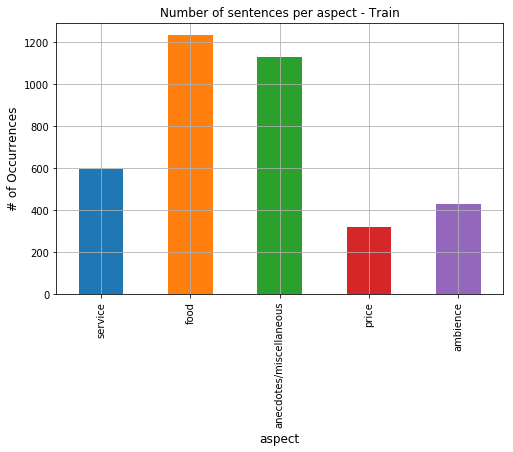

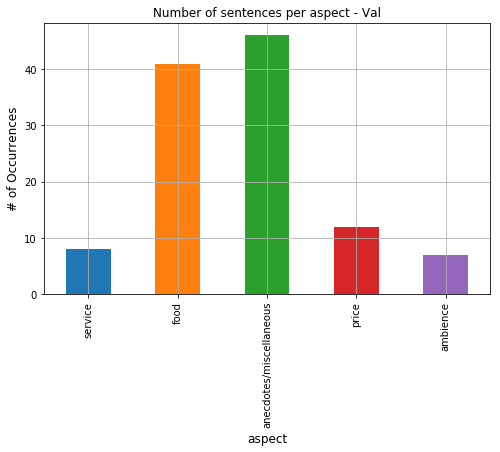

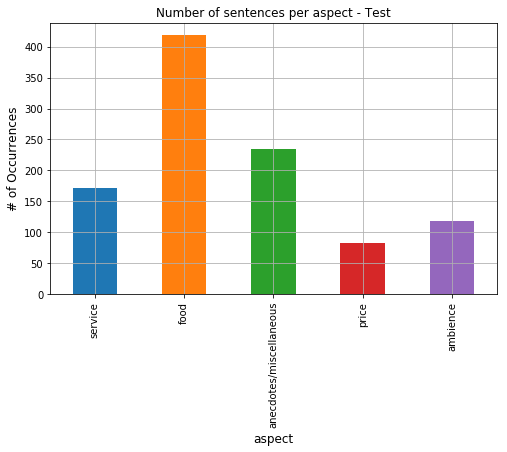

In [138]:
def plot_asp_stat(df_stats, dataset_name):
    df_stats.plot(x='aspect', y='num_of_sent',kind='bar', legend=False, grid=True, figsize=(8, 5))
    plt.title("Number of sentences per aspect - " + dataset_name)
    plt.ylabel('# of Occurrences', fontsize=12)
    plt.xlabel('aspect', fontsize=12)
plot_asp_stat(train_aspect_stats, "Train")
plot_asp_stat(val_aspect_stats, "Val")
plot_asp_stat(test_aspect_stats, "Test")